In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from category_encoders import BinaryEncoder, cat_boost
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

import torch
from torch import nn, optim

# Helpfull functions

In [2]:
def type_casting(df_in):
    df = df_in.copy()
    cat_features = ['store_id','region_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

In [3]:
def boxplots_top_stores(df, columns, num_stores=5):
    top_stores = df.value_counts('store_id').sort_values(ascending=False)[:num_stores].index

    _, axes = plt.subplots(nrows=len(columns), 
                        ncols=num_stores+2, figsize=(num_stores*5, len(columns) * 3))
    for idx, feature in enumerate(columns):
        sns.histplot(df[feature], 
                    stat='density', 
                    kde=True,
                    bins=35, ax=axes[idx, 0])
        sns.boxplot(x=feature, data=df, ax=axes[idx, 1]).set_xlabel(feature + ' for all stores')
        for shifted_idx, store_id in enumerate(top_stores, 2):
            sns.boxplot(x=feature, 
                        data=df[df['store_id']==store_id], 
                        ax=axes[idx, shifted_idx]).set_xlabel(feature + ' for ' + str(store_id))
    plt.tight_layout()

In [4]:
def sort_dates(df_in, date_columns):
    df = df_in.copy()
    mask_any_na_dates = df[date_columns].isna().any(axis=1)
    df.loc[~mask_any_na_dates, date_columns] = np.sort(df.loc[~mask_any_na_dates, date_columns].values, axis=1)
    return df

In [5]:
def rm_outliers(df_in, features, quantiles: np.array):
    assert len(features) == len(quantiles)
    df = df_in.copy()
    print('Shape before removing outliers: ', df.shape)
    IQR = stats.iqr(df[features], axis=0, nan_policy='omit')

    mask_non_outliers = df.groupby("store_id")[features]\
        .apply(lambda x : (x>=(np.diag(x.quantile(quantiles[:,0])) - 1.5 * IQR)) 
                        & (x<=(np.diag(x.quantile(quantiles[:,1])) + 1.5 * IQR))\
              ).all(axis=1).values
    df = df[mask_non_outliers]
    print('Shape after removing outliers: ', df.shape)
    return df

In [6]:
def impute_dates_by_store(x_in):
    x = x_in.copy()
    # calculate statistics value for recover null observation in regarding the neighbour date feature
    diff_date = x['order_pickup'] - x['order_ready']
    diff_timestamp_statistic = diff_date[diff_date > pd.to_timedelta("0 days")].mode()

    # From EDA, this column hasn't null rows, but to be sure this code will be left 
    # order_pickup = order_ready + mode(order_pickup - order_ready)
    mask_null_order_pickup = x['order_pickup'].isnull() 
    x.loc[mask_null_order_pickup, 'order_pickup'] = \
        x.loc[mask_null_order_pickup, 'order_ready'] + diff_timestamp_statistic
    
    # order_ready = order_pickup - mode(order_pickup - order_ready)
    mask_null_order_ready = x['order_ready'].isnull()
    x.loc[mask_null_order_ready, 'order_ready'] = \
        x.loc[mask_null_order_ready, 'order_pickup'] - diff_timestamp_statistic

    # New feature that relfects waiting time for the order to be accepted for processing
    x['order_delay'] = x['order_start_prepare'] - x['date_create']
    diff_timestamp_statistic = x['order_delay'][x['order_delay'] > pd.to_timedelta("0 days")].mode()
    x['order_delay'] = x['order_delay'].dt.total_seconds() / 60

    # order_start_prepare = date_create + mode(order_start_prepare - date_create)
    mask_null_order_start_prepare = x['order_start_prepare'].isnull()
    x.loc[mask_null_order_start_prepare, 'order_start_prepare'] = \
        x.loc[mask_null_order_start_prepare, 'date_create'] + diff_timestamp_statistic
    
    # date_create = order_start_prepare - mode(order_start_prepare - date_create)
    mask_null_date_create = x['date_create'].isnull()
    x.loc[mask_null_date_create, 'date_create'] = \
        x.loc[mask_null_date_create, 'order_start_prepare'] - diff_timestamp_statistic

    return x

In [7]:
def impute_dates(df_in):
    df = df_in.copy()
    # Restore dates within a certain store_id by mode of differences neighboor columns 
    # (order_pickup - order_ready) & (order_start_prepare - date_create)
    df.loc[:,['date_create','order_start_prepare','order_ready','order_pickup','order_delay']] = df.groupby("store_id")\
            .apply(lambda x: impute_dates_by_store(x))\
            .reset_index(allow_duplicates=True)\
            .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup','order_delay']]
    return df

In [8]:
def extract_target(df_in, q_target=0.75, test_subset=False):
    df = df_in.copy()
    df['actual_prep_time'] = (df['order_ready'] - df['order_start_prepare']).dt.total_seconds() / 60
    
    mask_null_prep_time = df['actual_prep_time'].isnull() 
    if not test_subset:
        df['diff_time'] = df['actual_prep_time'] - df['planned_prep_time']
        
        mask_neg_prep_time = df['actual_prep_time'] < 0
        IQR = stats.iqr(df['diff_time'], nan_policy='omit')
        mask_outliers_in_diff_time = df['diff_time'] > (df['diff_time'].quantile(q_target) + 1.5 * IQR)

        print("Nan's in actual_prep_time: ", mask_null_prep_time.sum(),
            "\nNegatives: ", mask_neg_prep_time.sum(),
            '\nOutliers in time difference: ', mask_outliers_in_diff_time.sum())
        
        df.drop(columns='diff_time', inplace=True)
        df.dropna(subset=['date_create','planned_prep_time'], inplace=True)
        mask_anomaly = mask_neg_prep_time | mask_null_prep_time | mask_outliers_in_diff_time
    else:
        mask_anomaly = mask_null_prep_time
    
    print("All anomalyes: ", df.loc[mask_anomaly].shape[0])
    df = df.loc[~mask_anomaly]
    df['on_time'] = np.where(abs(df['planned_prep_time'] - df['actual_prep_time']) <= 5, 1, 0)
    return df.drop(columns=['order_ready','order_pickup','actual_prep_time', 'on_time']), df['on_time']


In [9]:
def encode_cyclical_feat(df_in: pd.DataFrame, col: pd.Series, col_name: str):
    df = df_in.copy()
    df[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    df[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return df

In [10]:
def extract_date_feat(df_in: pd.DataFrame, data_features: list, drop=True, encode_cyclical=True):
    df = df_in.copy()
    if encode_cyclical:
        for col_name in data_features:
            df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
            df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
            df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
            df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
            df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    else:
        for col_name in data_features:
            df[col_name + '_month'] = df[col_name].dt.month
            df[col_name + '_day'] = df[col_name].dt.day
            df[col_name + '_weekday'] = df[col_name].dt.weekday
            df[col_name + '_hour'] = df[col_name].dt.hour
            df[col_name + '_minute'] = df[col_name].dt.minute
            
    if drop:
        df = df.drop(columns=data_features)
    return df

In [11]:
def scores(estimator, X_test, y_test, X_train, y_train, cv=5, cv_scoring='f1', threshold=0.5, plot=True, ax=None):
    if threshold:
        pred_proba = estimator.predict_proba(X_test)
        y_test_pred = np.where(pred_proba[:, 1] > threshold, 1, 0)
    else:
        y_test_pred = estimator.predict(X_test)

    # calculate metrics
    print('- Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
    print('- Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
    print('- Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))
    print('- Testing f1_score = {}'.format(metrics.f1_score(y_test, y_test_pred)))
    print('- Cross validate: ', cross_val_score(estimator, pd.concat([X_train, X_test]), 
                                                pd.concat([y_train, y_test]), cv=cv, scoring=cv_scoring).mean())
  
    if plot: 
        cm = confusion_matrix(y_test, y_test_pred, labels=estimator.classes_, 
                        #   normalize='true'
                        )
        ConfusionMatrixDisplay(cm, display_labels=estimator.classes_).plot(ax=ax)
        return cm
    

# EDA

In [12]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

In [13]:
X, y = extract_target(orders, 1.0)
date_columns = ['date_create', 'order_start_prepare']
df = pd.concat([X,y], axis=1)
df.shape

Nan's in actual_prep_time:  97930 
Negatives:  1855 
Outliers in time difference:  0
All anomalyes:  99716


(417620, 15)

([<matplotlib.patches.Wedge at 0x7f6dd1b0cbb0>,
 [Text(-0.14313714705728628, 1.0906474027532, 'Late'),
  Text(0.14313714705728586, -1.0906474027532, 'On time')],
 [Text(-0.0780748074857925, 0.5948985833199272, '54.2%'),
  Text(0.07807480748579228, -0.5948985833199273, '45.8%')])

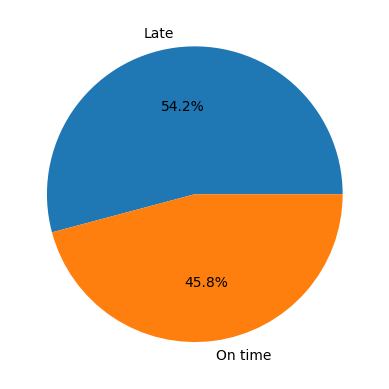

In [14]:
plt.pie(x=y.value_counts().values,
        labels=y.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

In [15]:
top_stores = df['store_id'].value_counts().index[:12]
print('Top stores: ', top_stores)
df_top_stores = df[df['store_id'].isin(top_stores)]
df_top_stores.shape

Top stores:  Index([3503, 5212, 5014, 4742, 3902, 3141, 4755, 3053, 6579, 3496, 3766,
       10489],
      dtype='object', name='store_id')


(52308, 15)

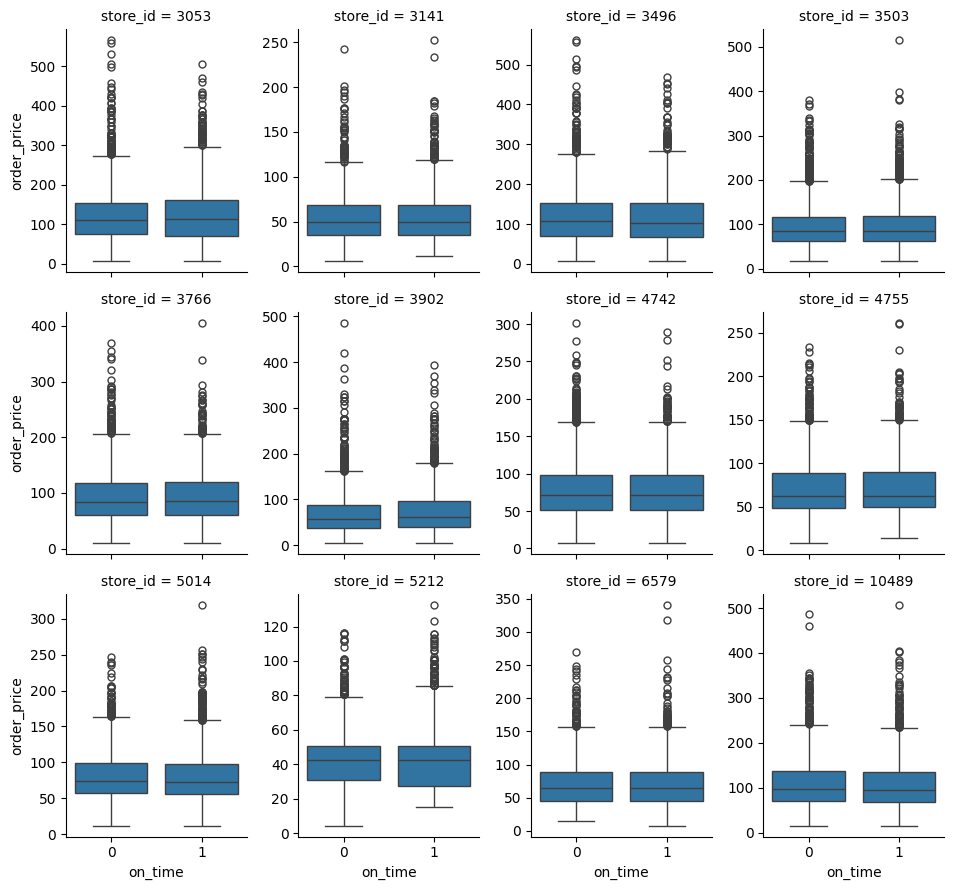

In [16]:
sns.catplot(
    x="on_time",
    y="order_price",
    col="store_id",
    data=df_top_stores,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8, sharey=False
)

In [17]:
df_extracted_dates = extract_date_feat(df_top_stores, date_columns, encode_cyclical=False)
df_extracted_dates.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'status_id', 'products_count', 'order_price', 'max_price',
       'min_price', 'avg_price', 'unique_products_sold_by_store', 'on_time',
       'date_create_month', 'date_create_day', 'date_create_weekday',
       'date_create_hour', 'date_create_minute', 'order_start_prepare_month',
       'order_start_prepare_day', 'order_start_prepare_weekday',
       'order_start_prepare_hour', 'order_start_prepare_minute'],
      dtype='object')

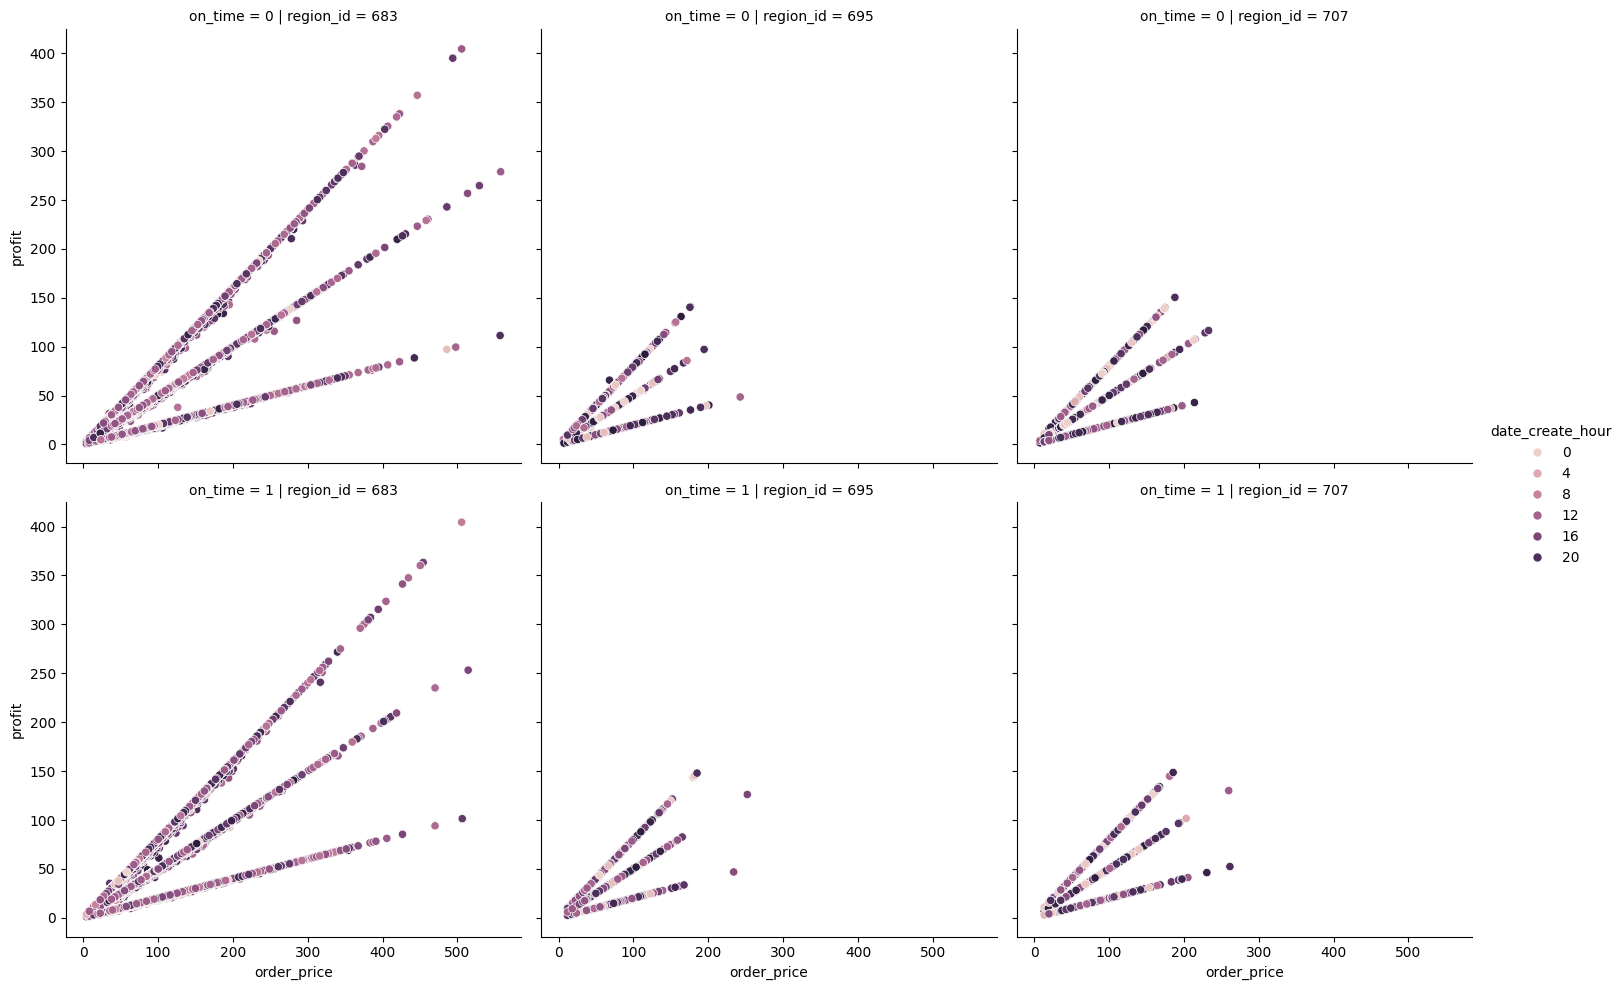

In [18]:
sns.relplot(df_extracted_dates, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='date_create_hour', #hue_order=(15, 90),
            col="region_id", row='on_time')

The same, but without outliers

Shape before removing outliers:  (417620, 23)


Shape after removing outliers:  (368308, 23)


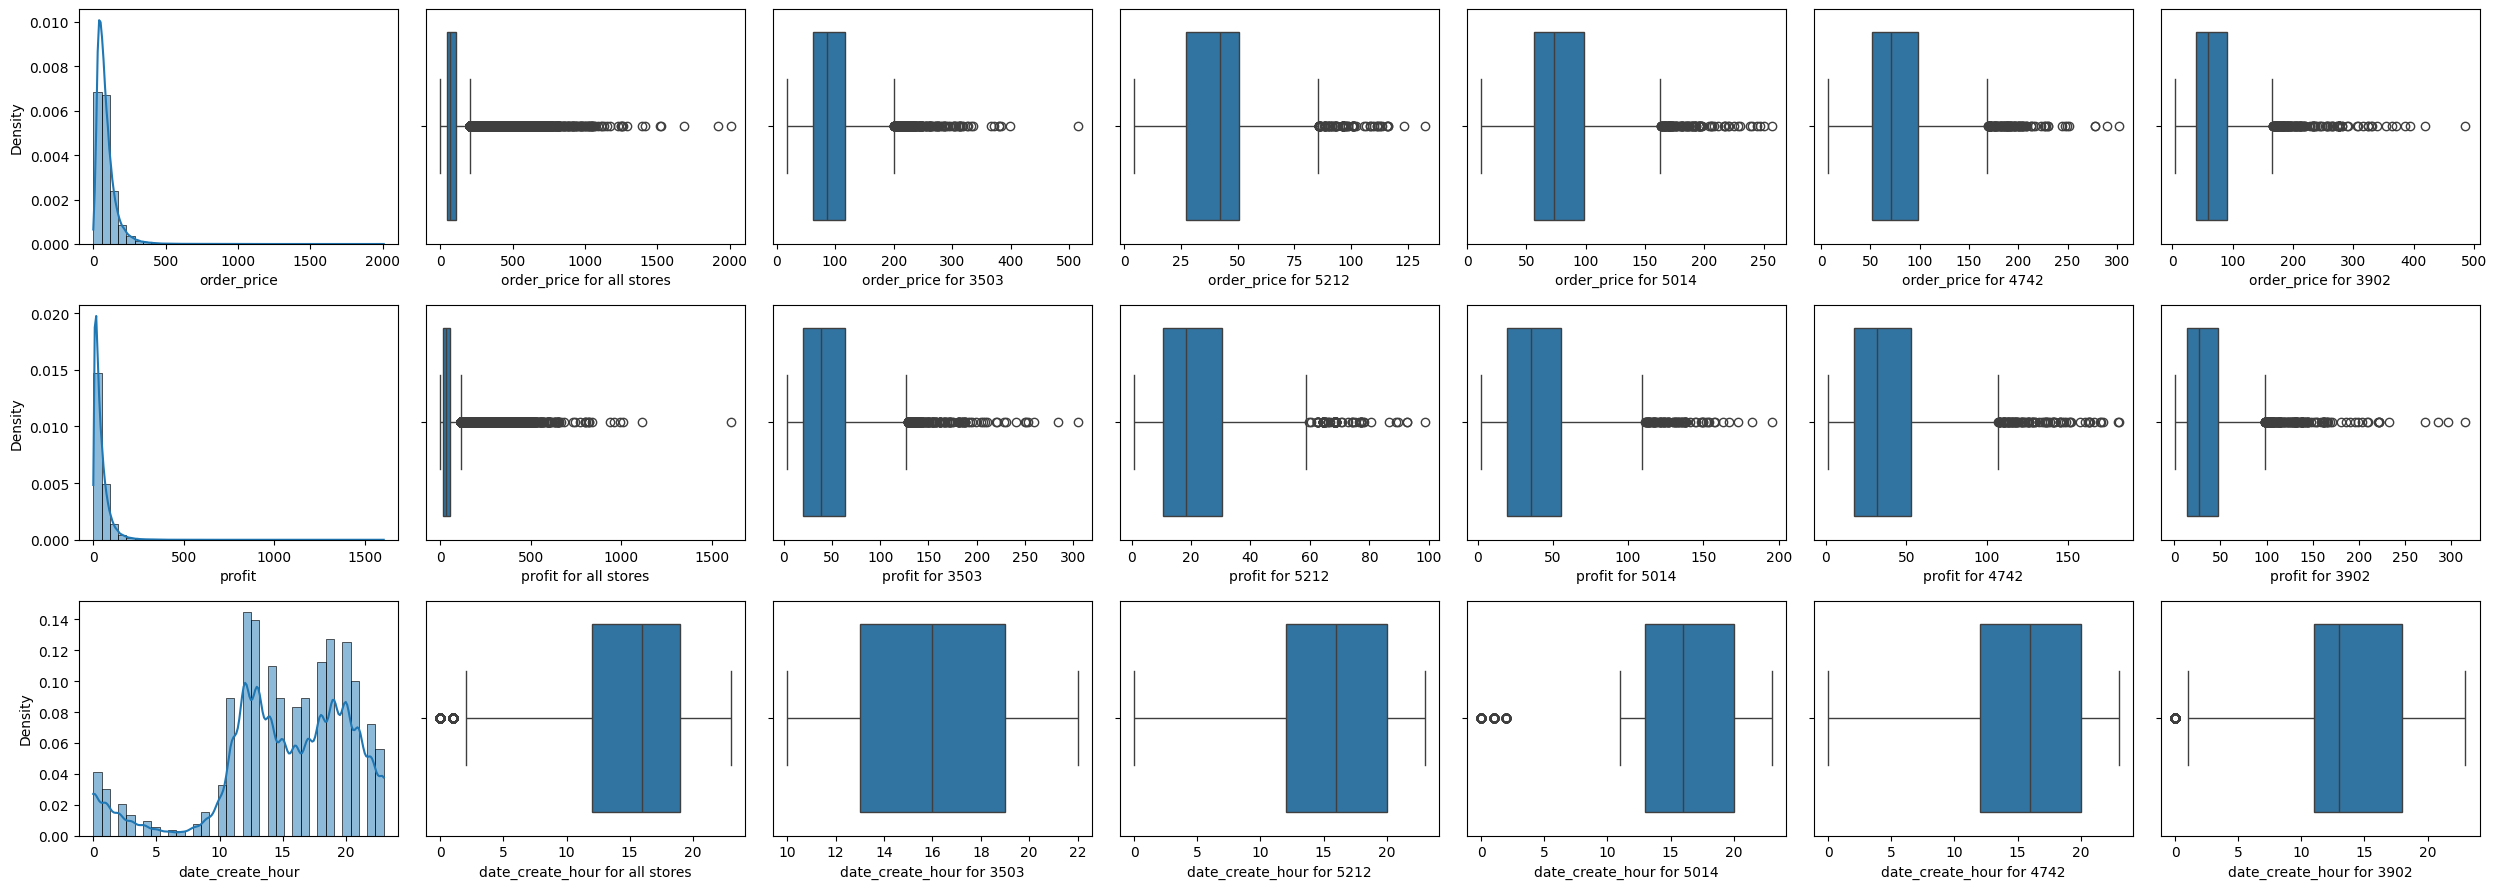

In [19]:
df_without_outliers = rm_outliers(extract_date_feat(df, date_columns, encode_cyclical=False), 
                                  ['order_price', 'profit'], np.array([[0.0, 0.9]]*2))
boxplots_top_stores(df_without_outliers, ['order_price', 'profit', 'date_create_hour'])

In [20]:
top_stores = df_without_outliers['store_id'].value_counts().index[:12]
print('Top stores: ', top_stores)
df_top_stores = df_without_outliers[df_without_outliers['store_id'].isin(top_stores)]
df_top_stores.shape

Top stores:  Index([3503, 5212, 5014, 4742, 3902, 3141, 4755, 3053, 6579, 3496, 3766,
       10489],
      dtype='object', name='store_id')


(46122, 23)

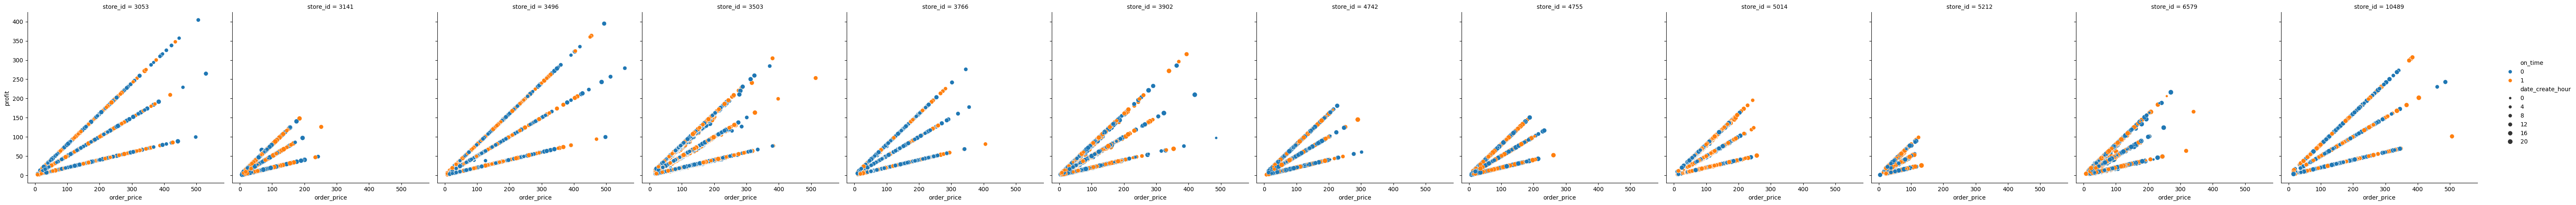

In [21]:
sns.relplot(df_top_stores, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='on_time', #hue_order=(15, 90),
            size='date_create_hour',
            col="store_id", 
            # row='region_id'
            )

# Preprocess the data

In [22]:
################ Hyperparameters for data preprocessing #######################
lower_outliers_bound = 0.0
upper_outliers_bound = 0.8
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']

sort_dates_on = False
test_subset = False
q_target = 0.7
imputing_method_for_dates = 'mode'

restore_numerical_nans = False
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
encoder_class = 'Catboost Encoder'
scaler_class = preprocessing.MinMaxScaler

In [23]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

In [24]:
if sort_dates_on:
    orders = sort_dates(orders, date_columns)

In [25]:
features_for_rm_outls = ['profit', 'delivery_distance','order_price','max_price','min_price']
# features_for_rm_outls = orders.select_dtypes('number').columns
quantiles = np.array([[lower_outliers_bound, upper_outliers_bound]]*len(features_for_rm_outls))

rmvd_outliers = rm_outliers(orders, features_for_rm_outls, quantiles)
# boxplots_top_stores(rmvd_outliers, features_for_rm_outls)

Shape before removing outliers:  (517610, 16)
Shape after removing outliers:  (427283, 16)


In [26]:
df_selected_feats = rmvd_outliers[selected_features]

## Split and so on

In [27]:
X_train, X_test = train_test_split(df_selected_feats, train_size=0.9, shuffle=False)

In [19]:
X_train = impute_dates(X_train)
X_test = impute_dates(X_test)

In [20]:
X_train, y_train = extract_target(X_train, q_target)
X_test, y_test = extract_target(X_test, test_subset=test_subset)
data_features = ['date_create','order_start_prepare']

Nan's in actual_prep_time:  72795 
Negatives:  1371 
Outliers in time difference:  11822
All anomalyes:  85908
Nan's in actual_prep_time:  8073 
Negatives:  154 
Outliers in time difference:  1073
All anomalyes:  9288


([<matplotlib.patches.Wedge at 0x7f3ef483c790>,
 [Text(-0.08057488196198336, 1.0970449801155888, 'Late'),
  Text(0.08057477924921908, -1.097044987659549, 'On time')],
 [Text(-0.04394993561562728, 0.5983881709721393, '52.3%'),
  Text(0.04394987959048313, -0.5983881750870266, '47.7%')])

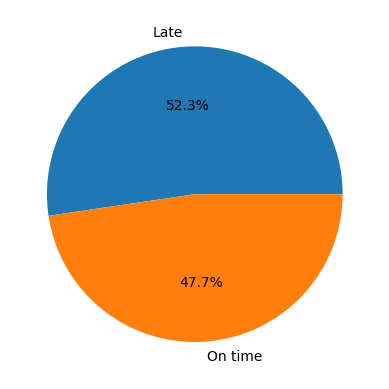

In [21]:
plt.pie(x=y_train.value_counts().values,
        labels=y_train.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

In [22]:
X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)
X_train.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'products_count', 'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store', 'order_delay', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos'],
      dtype='object')

In [23]:
na_columns_train = X_train.columns[X_train.isna().any()]
print("Numbers of NaN values\n\tTrain:\n", X_train[na_columns_train].isna().sum())
na_columns_test = X_test.columns[X_test.isna().any()]
print("\n\tTest:\n", X_test[na_columns_test].isna().sum())

if restore_numerical_nans:
    X_train.loc[:,na_columns_train] = X_train.groupby("store_id")\
        [na_columns_train].transform(lambda x: x.fillna(imputing_method_for_numerical(x)))
    X_test.loc[:,na_columns_test] = X_test.groupby("store_id")\
        [na_columns_test].transform(lambda x: x.fillna(imputing_method_for_numerical(x)))

    ####################################### Imputting #####################################
    col_imputing = X_test.columns[X_test.isna().any()].union(X_train.columns[X_train.isna().any()])

    print("Remaining numbers of NaN values\n\tTrain:\n", X_train[col_imputing].isna().sum())
    print("\n\tTest:\n", X_test[col_imputing].isna().sum())

    imputer = SimpleImputer(strategy=imputing_method_for_simple_imputer)
    X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), 
                                         columns=col_imputing, index=X_train.index)
    X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), 
                                        columns=col_imputing, index=X_test.index)
else:
    index_train_na, index_test_na = X_train[na_columns_train].isnull().any(axis=1), \
                                    X_test[na_columns_test].isnull().any(axis=1)    
    X_train, y_train, X_test, y_test = X_train[~index_train_na], y_train[~index_train_na], \
                                       X_test[~index_test_na], y_test[~index_test_na]

Numbers of NaN values
	Train:
 profit       29684
max_price      108
min_price      108
dtype: int64

	Test:
 profit       3273
max_price      17
min_price      17
dtype: int64


In [24]:
###################################### Encoding #####################################
cat_features = ['store_id','region_id']
encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [25]:
##################################### Scaling #####################################
scaler = scaler_class()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

In [26]:
X_train.shape, X_test.shape

((268669, 31), (30125, 31))

# Models

## Logistic Regression

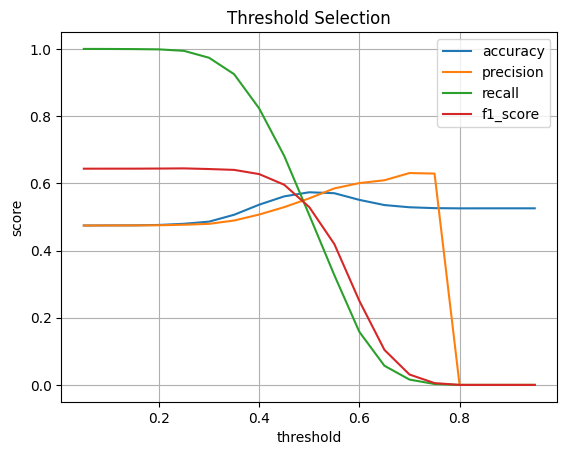

In [27]:
def logistic_regressor(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    thresholds = np.arange(0.05, 0.99, 0.05)
    pred_proba = clf.predict_proba(X_test)

    metric_funcs = [metrics.accuracy_score, 
                    metrics.precision_score, 
                    metrics.recall_score, 
                    metrics.f1_score]
    results = [[],[],[],[]]
    for i in thresholds:
        y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
        [
            results[idx].append(metric_func(y_test, y_test_pred_thr)) 
            for idx, metric_func 
            in enumerate(metric_funcs)
        ]

    [plt.plot(thresholds, results[idx], label=metric) 
    for idx, metric in enumerate(['accuracy', 'precision', 'recall', 'f1_score'])]
    plt.title('Threshold Selection')
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.legend()
    plt.grid()
    return clf

clf = logistic_regressor(X_train, y_train, X_test, y_test)

----Logistic Regression Coefficients----
- Testing accuracy = 0.573344398340249
- Testing precision = 0.5552651806302844
- Testing recall = 0.5054929676019873
- Testing f1_score = 0.529211384198381


- Cross validate:  0.530243669122649


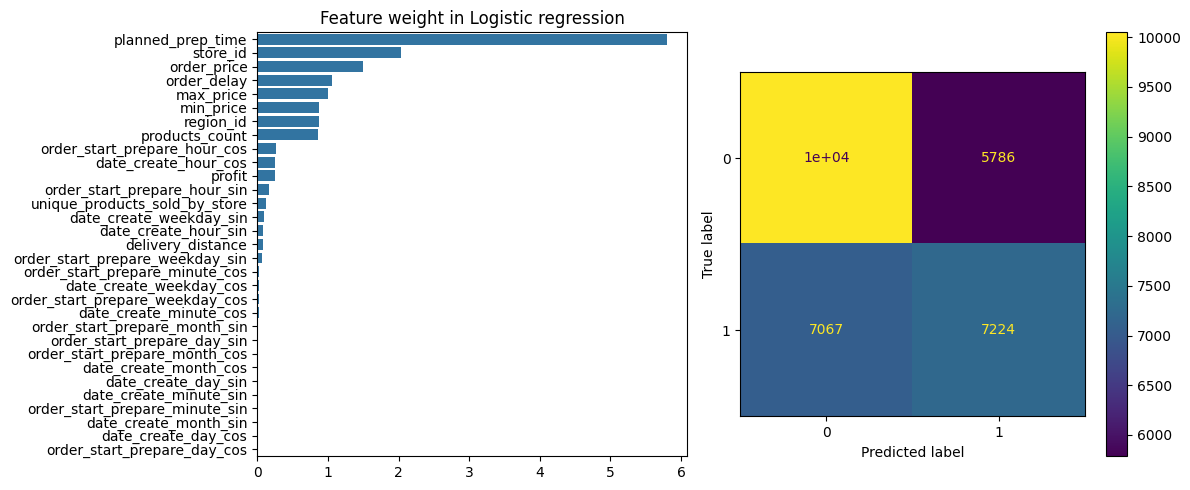

In [28]:
def logistic_regressor_scores(clf, X_test, y_test, X_train, y_train, cv=5, best_threshold=0.5):
    print("----Logistic Regression Coefficients----")
    importance_features = {col: abs(w)  for col, w in zip(list(X_train.columns), clf.coef_[0])}
    importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse=True))

    _, axes = plt.subplots(1,2, figsize=(12,5))
    sns.barplot(importance_features, 
                orient='h',
                ax=axes[0]).set_title('Feature weight in Logistic regression')

    scores(clf, X_test, y_test, X_train, y_train, cv, threshold=best_threshold, ax=axes[1])
    plt.tight_layout()
    plt.show()

logistic_regressor_scores(clf, X_test, y_test, X_train, y_train)

4. ################ Hyperparameters for data preprocessing #######################
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'most_frequent'
scaler_class = preprocessing.MinMaxScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5756413534475411
- Testing precision = 0.5625821091603965
- Testing recall = 0.7815662850506057
- Testing f1_score = 0.6542361111111111

5. ################ Hyperparameters for data preprocessing ####################### ================= BEST
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
scaler_class = preprocessing.MinMaxScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5756839682945538
- Testing precision = 0.562608228339404
- Testing recall = 0.7816492450638792
- Testing f1_score = 0.6542828374014791
6. ################ Hyperparameters for data preprocessing #######################
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mean'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
scaler_class = preprocessing.MinMaxScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.575774355424814
- Testing precision = 0.5581973030518098
- Testing recall = 0.7565617699601485
- Testing f1_score = 0.6424154025670945
7. ################ Hyperparameters for data preprocessing #######################
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'median'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
scaler_class = preprocessing.MinMaxScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5759734421467598
- Testing precision = 0.560505155147748
- Testing recall = 0.7721372748895685
- Testing f1_score = 0.6495169496369977
8. ################ Hyperparameters for data preprocessing #######################
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
scaler_class = preprocessing.RobustScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5753004346714395
- Testing precision = 0.562358141201768
- Testing recall = 0.781068524970964
- Testing f1_score = 0.653910265314627
9. ################ Hyperparameters for data preprocessing #######################
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
scaler_class = preprocessing.StandardScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5756413534475411
- Testing precision = 0.5625970612830008
- Testing recall = 0.7814003650240584
- Testing f1_score = 0.6541880816780108
10. ################ Hyperparameters for data preprocessing #######################
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
encoder_class = 'binary_encoder'
scaler_class = preprocessing.MinMaxScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5753856643654649
- Testing precision = 0.5870978496416069
- Testing recall = 0.5843703334992534
- Testing f1_score = 0.5857309163479129
11. ################ Hyperparameters for data preprocessing #######################
lower_outliers_bound = 0.1
upper_outliers_bound = 0.9
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
encoder_class = 'Catboost Encoder'
scaler_class = preprocessing.MinMaxScaler
----Logistic Regression Coefficients----
- Testing accuracy = 0.5756839682945538
- Testing precision = 0.562608228339404
- Testing recall = 0.7816492450638792
- Testing f1_score = 0.6542828374014791

12. ################ Hyperparameters for data preprocessing #######################
lower_outliers_bound = 0.0
upper_outliers_bound = 0.99
selected_features = ['store_id', 'profit','delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store']
sort_dates_on = False
test_subset = False
q_target = 0.9
imputing_method_for_dates = 'mode'
imputing_method_for_numerical = np.mean
imputing_method_for_simple_imputer = 'mean'
encoder_class = 'Catboost Encoder'
scaler_class = preprocessing.MinMaxScaler

----Logistic Regression Coefficients----
- Testing accuracy = 0.5781547144346972
- Testing precision = 0.5638213530655392
- Testing recall = 0.7687826556963546
- Testing f1_score = 0.6505399568034558

# Balancing dataset

In [29]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

(268669, 31) on_time
0    140595
1    128074
Name: count, dtype: int64
(281190, 31) on_time
0    140595
1    140595
Name: count, dtype: int64
----Logistic Regression Coefficients----
- Testing accuracy = 0.5686639004149378
- Testing precision = 0.5417551992788616
- Testing recall = 0.5887621580015394
- Testing f1_score = 0.5642814029910804
- Cross validate:  0.5314963270217459


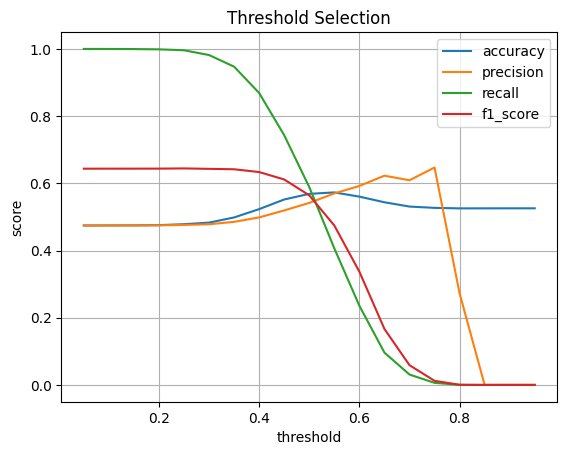

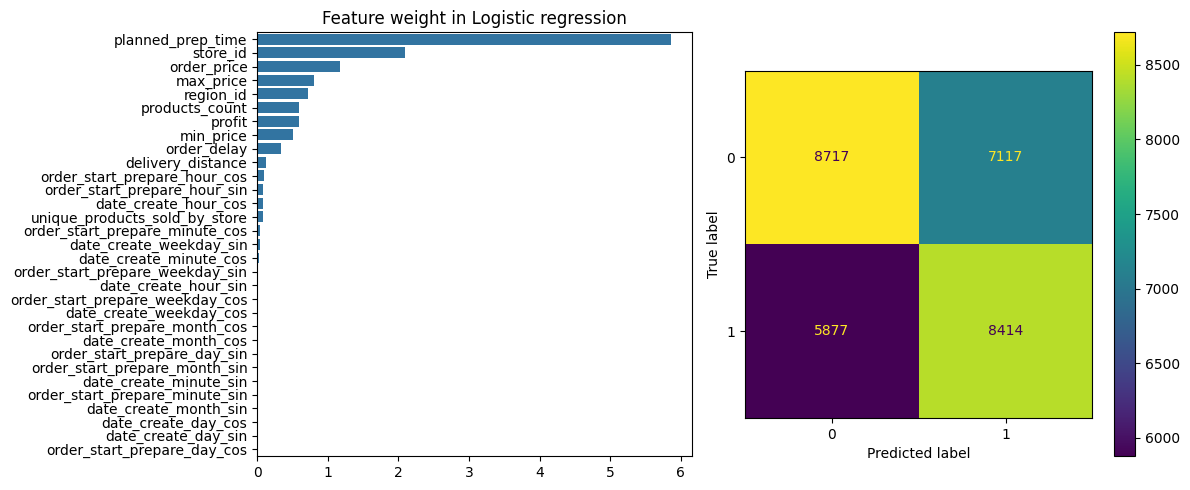

In [30]:
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=500).fit_resample(X_train, y_train)

print(X_train.shape, y_train.value_counts())
print(X_smote.shape, y_smote.value_counts())

clf_smote = logistic_regressor(X_smote, y_smote, X_test, y_test)
logistic_regressor_scores(clf_smote, X_test, y_test, X_smote, y_smote)

(268669, 31) on_time
0    140595
1    128074
Name: count, dtype: int64
(281190, 31) on_time
0    140595
1    140595
Name: count, dtype: int64
----Logistic Regression Coefficients----
- Testing accuracy = 0.5684315352697096
- Testing precision = 0.5412298644847865
- Testing recall = 0.5924707858092506
- Testing f1_score = 0.5656923333890095
- Cross validate:  0.5302297588909296


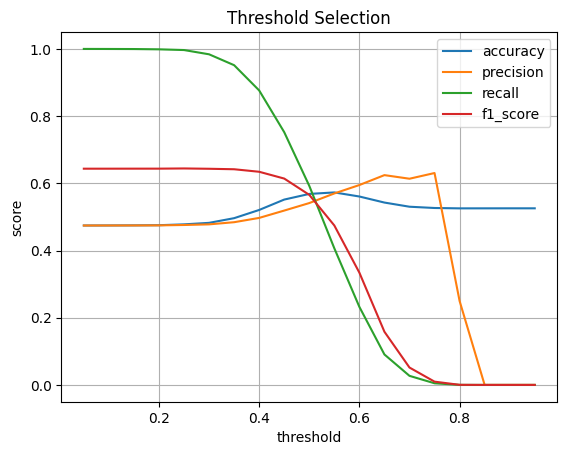

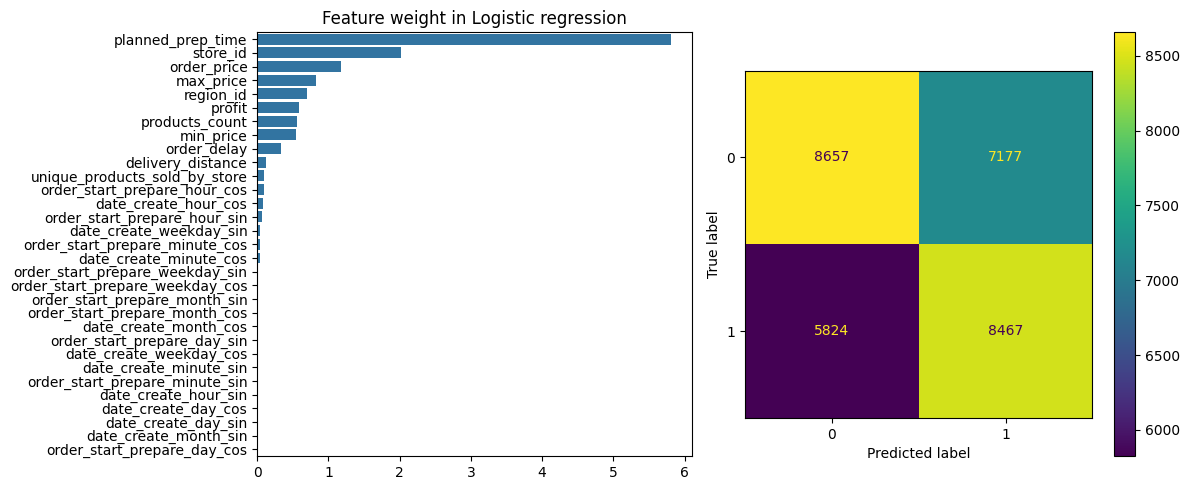

In [31]:
X_borderline_smote, y_borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=500)\
    .fit_resample(X_train, y_train)

print(X_train.shape, y_train.value_counts())
print(X_borderline_smote.shape, y_borderline_smote.value_counts())

clf_adasyn = logistic_regressor(X_borderline_smote, y_borderline_smote, X_test, y_test)
logistic_regressor_scores(clf_adasyn, X_test, y_test, X_borderline_smote, y_borderline_smote)


## SVC

In [32]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [ ]:
n_components = range(len(X_smote.columns)-3, len(X_smote.columns)+1)
for component in n_components:
    pca = PCA(n_components=component, random_state=42)
    X_train_svc = pca.fit_transform(X_smote)
    X_test_svc = pca.transform(X_test)

    svc = SVC(kernel='rbf', degree=4, C=1, max_iter=1000)
    svc.fit(X_train_svc, y_smote)

    # print("Support vectors: ", svc.support_vectors_) # get support vectors
    # print("indices of support vectors: ", svc.support_) # get indices of support vectors
    print("\nnumber of support vectors for each class: ", svc.n_support_,'\n\n') # get number of support vectors for each class

    scores(svc, pd.DataFrame(X_test_svc), y_test, pd.DataFrame(X_train_svc), y_train, threshold=None, plot=False)


number of support vectors for each class:  [1000 1000] 



number of support vectors for each class:  [1000 1000] 




- Testing accuracy = 0.5257759336099586
- Testing precision = 0.5010931351114998
- Testing recall = 0.08019032957805612
- Testing f1_score = 0.13825551936301123
- Cross validate:  0.050652616655449414


array([[14693,  1141],
       [13145,  1146]])

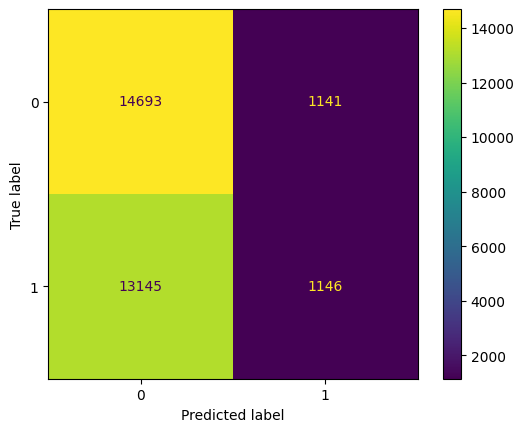

In [38]:
scores(svc, pd.DataFrame(X_test_svc), y_test, pd.DataFrame(X_train_svc), y_train, threshold=None, plot=True)

## Neural Network (MLP)

In [47]:
import torch
from torch import nn, optim

In [90]:
selected_features = ['store_id', 'profit', 'delivery_distance', 'region_id', 'status_id',
       'products_count', 'order_price',
       'unique_products_sold_by_store',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos']

In [1]:
X_train_sel, X_test_sel = X_train[selected_features], X_test[selected_features]

NameError: name 'X_train' is not defined

In [92]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = (torch.tensor(batch.values, dtype=torch.float32, device='cuda') 
                                                                for batch 
                                                                in (X_train_sel, X_test_sel, y_train, y_test))

type(X_train_tensor), X_train_tensor.shape, type(y_train_tensor), y_train_tensor.shape

(torch.Tensor, torch.Size([439926, 10]), torch.Tensor, torch.Size([439926]))

In [93]:
model = nn.Sequential(nn.LazyLinear(10), nn.ReLU(), 
                      nn.LazyLinear(32), nn.ReLU(), 
                      nn.LazyLinear(8), nn.ReLU(), 
                      # nn.LazyLinear(32), nn.ReLU(), 
                      nn.LazyLinear(1), nn.ReLU(), nn.Dropout(p=0.5))
model = model.to('cuda')


mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []

In [101]:
epochs = 1000
lr = 0.00001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)


for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    mean_train_losses.append(np.mean(train_losses))
   
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))


epoch : 1, train loss : 2618585.0000
epoch : 2, train loss : 2618585.0000
epoch : 3, train loss : 2618585.0000
epoch : 4, train loss : 2618585.0000
epoch : 5, train loss : 2618585.0000
epoch : 6, train loss : 2618585.0000
epoch : 7, train loss : 2618585.0000
epoch : 8, train loss : 2618585.0000
epoch : 9, train loss : 2618585.0000
epoch : 10, train loss : 2618585.0000
epoch : 11, train loss : 2618585.0000
epoch : 12, train loss : 2618585.0000
epoch : 13, train loss : 2618585.0000
epoch : 14, train loss : 2618585.0000
epoch : 15, train loss : 2618585.0000
epoch : 16, train loss : 2618585.0000
epoch : 17, train loss : 2618585.0000
epoch : 18, train loss : 2618585.0000
epoch : 19, train loss : 2618585.0000
epoch : 20, train loss : 2618585.0000
epoch : 21, train loss : 2618585.0000
epoch : 22, train loss : 2618585.0000
epoch : 23, train loss : 2618585.0000
epoch : 24, train loss : 2618585.0000
epoch : 25, train loss : 2618585.0000
epoch : 26, train loss : 2618585.0000
epoch : 27, train los

In [103]:
pred_proba

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746

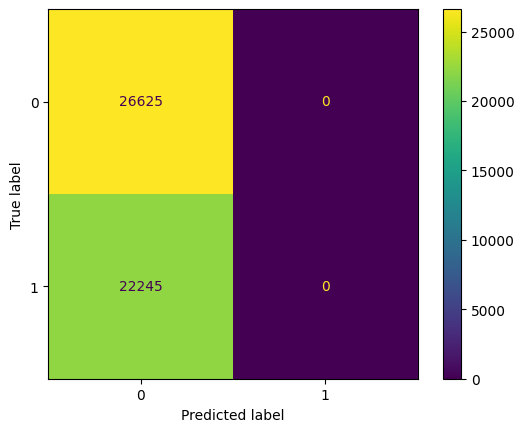

In [102]:
model = model.eval()
model = model.to('cuda')

pred_proba = model(X_test_tensor)
pred_proba = pred_proba.to('cpu').detach().numpy()

best_threshold, prev_precision = 0.3, 0
for threshold in np.linspace(0.3, 0.9, 10):

    y_test_pred = np.where(pred_proba > threshold, 1, 0)
    # calculate metrics
    print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
    precision = metrics.precision_score(y_test, y_test_pred)
    print('Testing precision = {}'.format(precision))
    if precision > prev_precision:
        best_threshold = threshold
    print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))
    print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_test_pred)), end='\n\n')

y_test_pred = np.where(pred_proba > best_threshold, 1, 0)
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1], 
                #   normalize='true'
                )
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()